In [2]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [11]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
# image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'
image_path = "/home/han/Documents/repos/ShowUI/datasets/ScreenSpot/images/" + "pc_db6b6fa2-11cc-4b06-88cb-22c180f07a3b.png"

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (960, 540)

0: 736x1280 59 icons, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 66 26
time to get parsed content: 0.14213180541992188


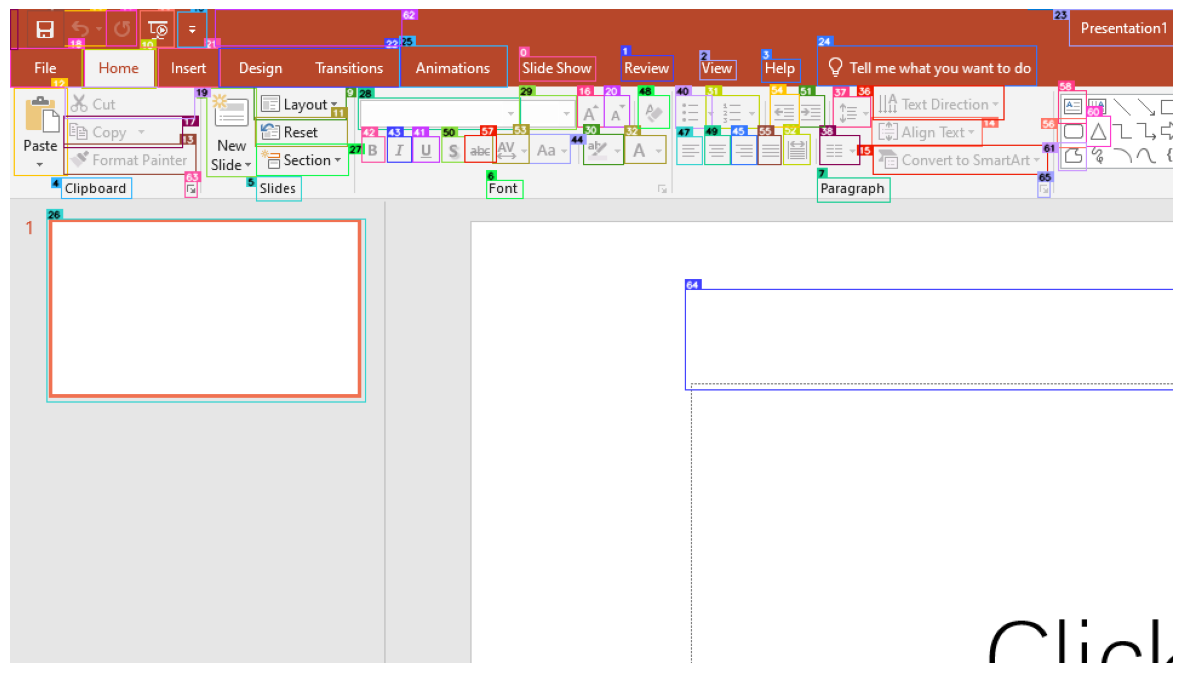

In [13]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))
plt.savefig("tmp_labeled_img", bbox_inches='tight', pad_inches=0, dpi=300)
# plt.close()  # 關閉圖表，避免顯示


In [14]:
# 增加 id 欄位到 parsed_content_list
for idx, item in enumerate(parsed_content_list, start=0):
    item['id'] = idx

print(parsed_content_list)

[{'type': 'text', 'bbox': [0.4375, 0.07222222536802292, 0.503125011920929, 0.10925926268100739], 'interactivity': False, 'content': ' Slide Show', 'source': 'box_ocr_content_ocr', 'id': 0}, {'type': 'text', 'bbox': [0.5249999761581421, 0.07037036865949631, 0.5697916746139526, 0.10925926268100739], 'interactivity': False, 'content': ' Review', 'source': 'box_ocr_content_ocr', 'id': 1}, {'type': 'text', 'bbox': [0.5927083492279053, 0.07777778059244156, 0.6239583492279053, 0.10740740597248077], 'interactivity': False, 'content': 'View', 'source': 'box_ocr_content_ocr', 'id': 2}, {'type': 'text', 'bbox': [0.6458333134651184, 0.07592592388391495, 0.6791666746139526, 0.1111111119389534], 'interactivity': False, 'content': 'Help', 'source': 'box_ocr_content_ocr', 'id': 3}, {'type': 'text', 'bbox': [0.04479166492819786, 0.25925925374031067, 0.10520832985639572, 0.2907407283782959], 'interactivity': False, 'content': 'Clipboard', 'source': 'box_ocr_content_ocr', 'id': 4}, {'type': 'text', 'bbox

In [15]:
label_coordinates

{'0': [0.4375, 0.07222222222222222, 0.065625, 0.037037037037037035],
 '1': [0.525, 0.07037037037037037, 0.04479166666666667, 0.03888888888888889],
 '2': [0.5927083333333333, 0.07777778484203197, 0.03125, 0.02962962962962963],
 '3': [0.6458333333333334,
  0.07592592592592592,
  0.03333333333333333,
  0.03518518518518519],
 '4': [0.0447916587193807,
  0.25925923100224246,
  0.06041666666666667,
  0.03148148148148148],
 '5': [0.21145833333333333,
  0.25555555555555554,
  0.03854166666666667,
  0.037037037037037035],
 '6': [0.409375, 0.2611111111111111, 0.03125, 0.027777777777777776],
 '7': [0.69375, 0.2574074074074074, 0.0625, 0.037037037037037035],
 '8': [0.16880982716878254,
  0.12179602163809317,
  0.043202781677246095,
  0.13521443119755497],
 '9': [0.20997996330261232,
  0.11870052196361401,
  0.07948034604390462,
  0.05044318305121528],
 '10': [0.06180236339569092,
  0.06113229680944372,
  0.06372289657592774,
  0.059750853644477],
 '11': [0.21043132146199545,
  0.16550154509367765,

In [9]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,id,ID
0,text,"[0.4375, 0.07222222536802292, 0.50312501192092...",False,Slide Show,box_ocr_content_ocr,0,0
1,text,"[0.5249999761581421, 0.07037036865949631, 0.56...",False,Review,box_ocr_content_ocr,1,1
2,text,"[0.5927083492279053, 0.07777778059244156, 0.62...",False,View,box_ocr_content_ocr,2,2
3,text,"[0.6458333134651184, 0.07592592388391495, 0.67...",False,Help,box_ocr_content_ocr,3,3
4,text,"[0.04479166492819786, 0.25925925374031067, 0.1...",False,Clipboard,box_ocr_content_ocr,4,4
...,...,...,...,...,...,...,...
61,icon,"[0.9017335772514343, 0.20434369146823883, 0.92...",True,Page,box_yolo_content_yolo,61,61
62,icon,"[0.17707602679729462, 0.00033974647521972656, ...",True,a button to close or close a window.,box_yolo_content_yolo,62,62
63,icon,"[0.15054099261760712, 0.26298677921295166, 0.1...",True,&Open File,box_yolo_content_yolo,63,63
64,icon,"[0.5810787081718445, 0.42780977487564087, 1.0,...",True,"M0,0L9,0 4.5,5z",box_yolo_content_yolo,64,64


In [10]:
parsed_content_list[93]

IndexError: list index out of range